# Exploring Sentence Processing: Hebrews
Let's explore using the nlp library `spaCy` for processing sentences to extract, meaning and summaries. 
For this we will use the the book of Hebrews from the NIV bible.

In [1]:
import spacy
nlp = spacy.load("en_core_web_md")

We will read in the document as one string to then parse with spaCy.

In [2]:
file = open('hebrews.txt', mode='r')
all_text = file.read()
file.close()

In [3]:
doc = nlp(all_text)

The document can be split into document spans of the sentences.

In [4]:
doc_sents = [sent for sent in doc.sents]

In [5]:
doc_sents[0].__class__

spacy.tokens.span.Span

We can treat these spans as individual documents for our purpose, although if we could make them into documents with the `Span.as_doc()` method.

In [6]:
for tok in doc_sents[3]:
    print(tok.lemma_, tok.lower_)

so so
-PRON- he
become became
as as
much much
superior superior
to to
the the
angel angels
as as
the the
name name
-PRON- he
have has
inherit inherited
be is
superior superior
to to
-PRON- theirs
. .
   


There are some empty sentences, we will remove these.

In [7]:
for sent in doc_sents:
    if len(sent) < 3:
        doc_sents.remove(sent)

In [8]:
len(doc_sents)

338

### Clustering Sentences
Lets create a matrix of sentence vectors. Spacy will automatically avergage all word vectors in a sentence to create a single vector. The vector is the numeric representation of the semantics of a sentence.

In [9]:
import numpy as np

In [10]:
smat = np.vstack([sent.vector for sent in doc_sents])

In [11]:
smat.shape

(338, 300)

Now we will cluster this data. I want to test looking at the centroid of each cluster, and see if these sentences could be used as a summary of the document.

In [12]:
from sklearn.cluster import KMeans

Lets try to get the optimal number of clusters using the elbow method.

In [13]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=123)
    km = km.fit(smat)
    Sum_of_squared_distances.append(km.inertia_)

In [14]:
import matplotlib.pyplot as plt

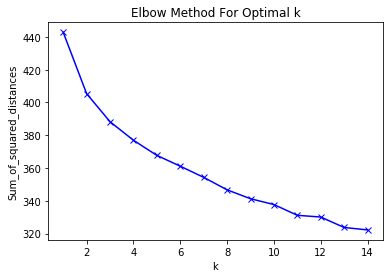

In [15]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It is sort of ambigous, lets use 4 for now.

In [16]:
kmeans = KMeans(n_clusters=3, random_state=123)

In [17]:
sent_clusters = kmeans.fit(smat)

In [18]:
np.unique(sent_clusters.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([128,  79, 131]))

Now lets take the sentence closest to the centroid of each cluster.

In [19]:
from sklearn.metrics import pairwise_distances_argmin_min

In [20]:
closest, _ = pairwise_distances_argmin_min(sent_clusters.cluster_centers_, smat)

In [21]:
closest

array([167,  86, 107])

In theory, the centroid of these clusters, should give us a sense of the meaning of these clusters. Looking at them all together would give a simplified look at the collective meaning, or summary, of the document.

In [22]:
print('_' * 30)
for sent, clust_id in zip(np.array(doc_sents)[closest], range(3)):
    print()
    print('Cluster: ' + str(clust_id))
    print(sent)
print('_' * 30)

______________________________

Cluster: 0
When Christ came as high priest of the good things that are already here, he went through the greater and more perfect tabernacle that is not man-made, that is to say, not a part of this creation.  

Cluster: 1
Although he was a son, he learned obedience from what he suffered  and, once made perfect, he became the source of eternal salvation for all who obey him  and was designated by God to be high priest in the order of Melchizedek.  

Cluster: 2
God did this so that, by two unchangeable things in which it is impossible for God to lie, we who have fled to take hold of the hope offered to us may be greatly encouraged.  
______________________________


This gives us the sentence that best summarizes the meaning in each cluster. 
We can see the first discusses the priesthood of Christ, the second the sacrafice, and the third the character of God.

**Visualize the Data**  
Lets take a look at the data, and further explore these clusters.

In [23]:
import seaborn as sns

In [24]:
from sklearn.decomposition import PCA

We can use the first two principle components to transform the data to 2 dimensions for plotting.

In [25]:
pca = PCA(n_components=2)

In [26]:
fplot = pca.fit_transform(smat)

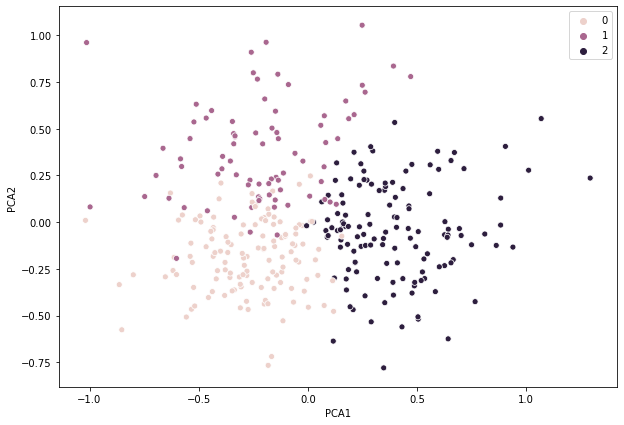

In [27]:
plt.figure(figsize=(10, 7))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
p1 = sns.scatterplot(x=fplot[:,0], y=fplot[:,1],
                     hue=sent_clusters.labels_,
                     legend='full')

**Samples from Clusters**  
Let's look at the k nearest neighbors to the centroid of the clusters. This will give us a better sense of the information in each cluster.

In [28]:
from sklearn.neighbors import NearestNeighbors

In [29]:
nene = NearestNeighbors(n_neighbors=5, metric='cosine')

In [30]:
nene.fit(smat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [31]:
n_clust = len(sent_clusters.cluster_centers_)
for centroid, clust_id in zip(sent_clusters.cluster_centers_, range(n_clust)):
    nn_a = nene.kneighbors(centroid.reshape(1, -1), 3)[1]
    print('Cluster: ' + str(clust_id))
    print("-"*30)
    for sent in np.array(doc_sents)[nn_a][0]:
        print(sent)
        print()

Cluster: 0
------------------------------
When Christ came as high priest of the good things that are already here, he went through the greater and more perfect tabernacle that is not man-made, that is to say, not a part of this creation.  

For this reason he had to be made like his brothers in every way, in order that he might become a merciful and faithful high priest in service to God, and that he might make atonement for the sins of the people.  

It is impossible for those who have once been enlightened, who have tasted the heavenly gift, who have shared in the Holy Spirit,  who have tasted the goodness of the word of God and the powers of the coming age,  if they fall away, to be brought back to repentance, because to their loss they are crucifying the Son of God all over again and subjecting him to public disgrace.  

Cluster: 1
------------------------------
Although he was a son, he learned obedience from what he suffered  and, once made perfect, he became the source of etern

Looking at the sentences closet to the centroid of each cluster we can confirm the meaning of these groups.